# Clone of the INDIV operational beam

In [2]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.08.29
Your IP is 172.17.0.13
2017-10-24 12:54:30
---


In [3]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.29/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 170 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.29/data/2017.08.29.17.54.49.685.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.29/data/2017.08.29.20.16.47.163.mat


## Load the data

In [4]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value'],verbose=False)                                                        

In [5]:
shiftVal=1

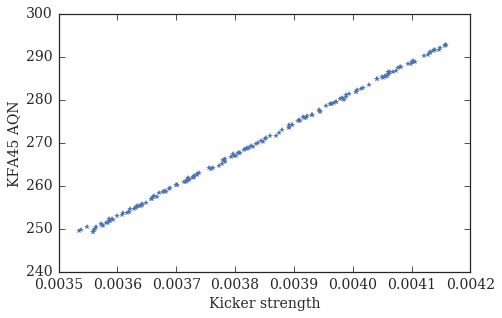

In [6]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.xlabel('Kicker strength')
plt.ylabel('KFA45 AQN')

## Intensity

In [7]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][1400]/np.max(x) )

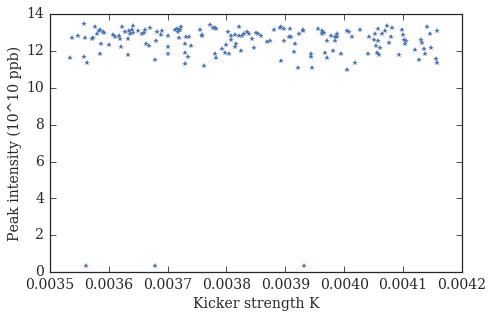

In [8]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
#plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

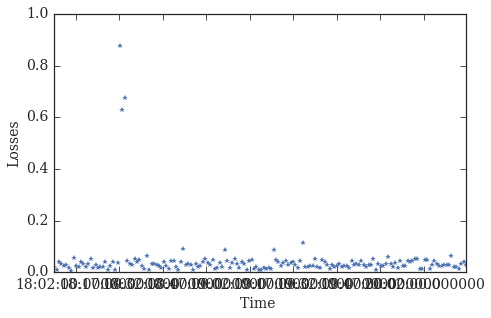

In [9]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

## BPMs

In [10]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

Kick: 0.003592


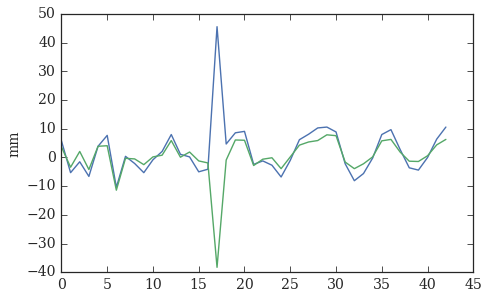

In [11]:
idx = 100

print 'Kick: '+str(myDataFrame['logical_PI_KFA45.K.value'].values[idx])

plt.plot(myDataFrame['BPMx_turn1'].values[idx])
plt.plot(myDataFrame['BPMx_turn2'].values[idx])

plt.ylabel('mm')

plt.show()

## Calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [12]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['deltaX_2turns'] = deltaXrms
myDataFrame['OrbitX_dev_RMS'] = delta_1st_orbit

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['deltaY_2turns'] = deltaXrms
myDataFrame['OrbitY_dev_RMS'] = delta_1st_orbit

(0.0035000000000000001, 0.0041999999999999997, 0, 20)

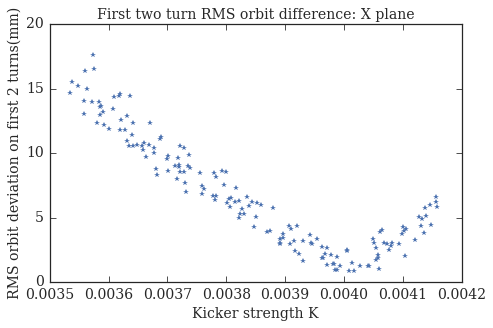

In [13]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference: X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,20))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

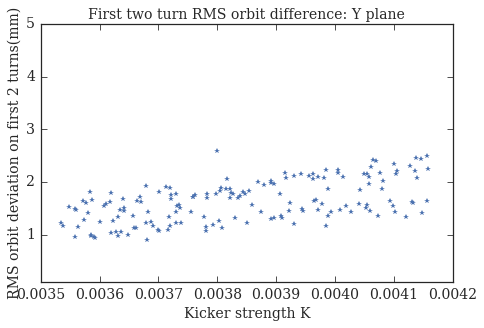

In [14]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference: Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.1,5))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

(0.0035000000000000001, 0.0041999999999999997, 0, 20)

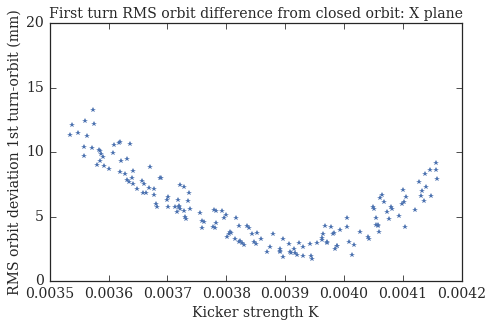

In [15]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitX_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,20))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

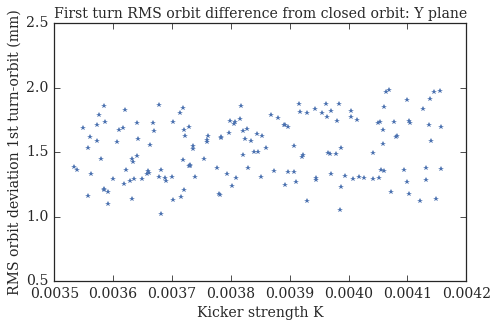

In [16]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: Y plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.5,2.5))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

# Fittings

In [17]:
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import leastsq

In [18]:
# data 
xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal).values
ydata = myDataFrame['deltaX_2turns'].values

Model function: a+b|x+c|
Fit params: a=0.0 b= 30000.0 c= -0.00401


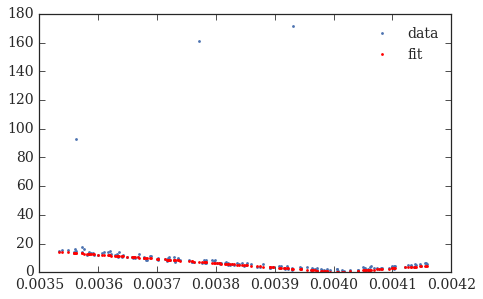

In [19]:
# homemade least square fit
def absFun(x, a, b, c):
    return a + b*np.abs(x+c)

def residual(p, x, y):
    return y - absFun(x, *p)
# initial params
p0 = [0, 3e4, -0.00401]
# fit
popt, pcov = leastsq(residual, p0, args=(xdata, ydata))

#plot data
plt.plot(xdata, ydata, '.',label='data')

#fit and plot fit
print 'Model function: a+b|x+c|'
print 'Fit params: a=' + str(popt[0]) + ' b= ' + str(popt[1]) + ' c= '+ str(popt[2])
plt.plot(xdata, absFun(xdata, *popt), 'r.', label='fit')


plt.legend()

In [20]:
# data 
xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal).values
ydata = myDataFrame['OrbitX_dev_RMS'].values

Model function: a+b|x+c|
Fit params: a=0.0 b= 30000.0 c= -0.00401


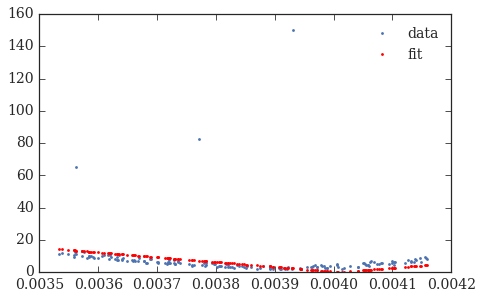

In [21]:
# homemade least square fit
def absFun(x, a, b, c):
    return a + b*np.abs(x+c)

def residual(p, x, y):
    return y - absFun(x, *p)
# initial params
p0 = [0, 3e4, -0.00401]
# fit
popt, pcov = leastsq(residual, p0, args=(xdata, ydata))

#plot data
plt.plot(xdata, ydata, '.',label='data')

#fit and plot fit
print 'Model function: a+b|x+c|'
print 'Fit params: a=' + str(popt[0]) + ' b= ' + str(popt[1]) + ' c= '+ str(popt[2])
plt.plot(xdata, absFun(xdata, *popt), 'r.', label='fit')


plt.legend()

## Wire scanner

### X plane

In [22]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [23]:
#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  

/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Y plane

In [25]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [26]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [27]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

### Tomogram

In [28]:
# load the dataframe from tomogram analysis
tomoDf = pnd.read_pickle('tomo_out_2017_08_29_ps.pkl') 
# work out the dataframe for the alignment
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
# set tolerance to align the timestamps
timeTolerance = 25 # [seconds]

In [29]:
succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomoDf)):
    tomo_local_cs = tomoDf['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    #stuff to copy here
    current_dpprms = tomoDf['deltaP_P_RMS'].values[k]
    current_pkld = tomoDf['peakLineDensity'].values[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x] = current_dpprms
            myDataFrame['peakLineDensity'].iloc[x]=current_pkld

            
            succ_count += 1 #dummy counter
print str(succ_count) +"/"+ str(len(tomoDf)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

169/176 are within the timeTolerance
length of dataframe is: 170


In [30]:
# discard the elements without tomogram (are probably double shots of matlab)
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

## Emitance

In [31]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.24577470 #at wirescanner 65
#     betax = 13.00860302 #at wirescanner 68
    betax = 21.77988929 #at wirescanner 65
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [32]:
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

In [33]:
# plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.')
# plt.xlabel('Kicker strength K (arb.u.)')
# plt.ylabel('Normalised emittance (mm.mrad)')
# # plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,.4,2))
# # IMPORTANT NOTE: the gaussian smears out at low kicker strenghts --> error on the emittance is bigger 

### X plane

In [34]:
myDataFrame['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],5.52e-4)

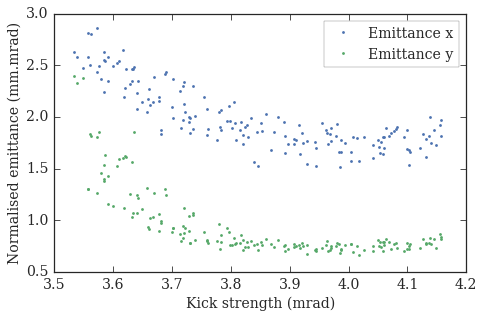

In [35]:
Emittance_x, = plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.',label='Emittance x')
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,.5,3))


Emittance_y, = plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.',label='Emittance y')

legend = plt.legend(handles=[Emittance_x,Emittance_y],frameon=True)

plt.show()

## Comparison to theory

In [36]:
# data cleanup: remove the 3 scattered points
for k in range(3):
    print myDataFrame['WS_emittance_x'].max()
    ts_min = myDataFrame['WS_emittance_x'].idxmax()
    print ts_min
    print myDataFrame['WS_emittance_x'].loc[ts_min]
    myDataFrame = myDataFrame.drop(ts_min)

21.0370028141
2017-08-29 18:17:58.300000
21.0370028141
14.6231574542
2017-08-29 18:18:54.700000
14.6231574542
12.3394802822
2017-08-29 18:17:07.900000
12.3394802822


Model function: a(x - b)^2 + c
Fit params: a=4.31040580268 b= 0.0040052703765 c= 1.73621441462e-06


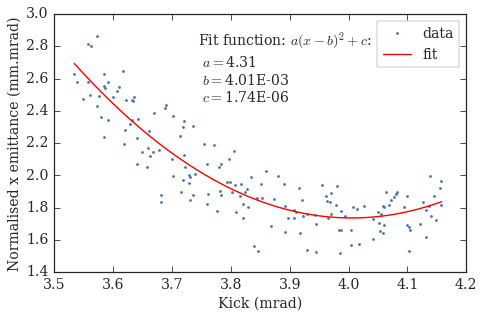

In [37]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_emittance_x'].values[1:]

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='data') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)')
plt.ylabel('Normalised x emittance (mm.mrad)')
plt.legend(frameon=True)

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

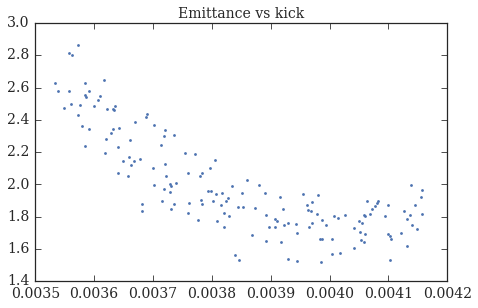

In [38]:
# emittance vs kick
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.3,3.2))
plt.title('Emittance vs kick')

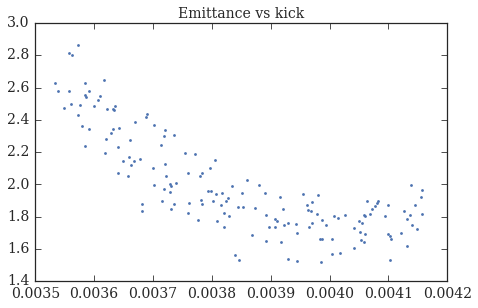

In [39]:
# emittance vs kick
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.3,3.2))
plt.title('Emittance vs kick')

2017-08-29 18:13:01.900000    k = 0.0036781.51872556951
fit result: y=0.0480863912326x + 1.08350796732


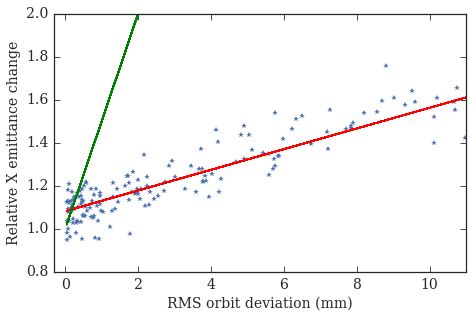

In [40]:
# pick the data with the smallest emittance
min_ts = myDataFrame['WS_emittance_x'].idxmin()
print str(min_ts) + '    k = ' + str(myDataFrame['logical_PI_KFA45.K.value'].loc[min_ts]) +  str(myDataFrame['WS_emittance_x'].loc[min_ts])

emiMin = myDataFrame['WS_emittance_x'].loc[min_ts]
sigmaMin = myDataFrame['WS_sigma_x'].loc[min_ts]

# manual correction
emiMin = 1.6
sigmaMin = 4.4


x = (myDataFrame['deltaX_2turns'].values / sigmaMin)**2
y = (myDataFrame['WS_emittance_x'])/emiMin

params, cov_mat = np.polyfit(x,y,1,full=False,cov=True)

#plotting
plt.plot(x, y,'*')
plt.xlabel('RMS orbit deviation (mm)')
plt.ylabel('Relative X emittance change')

plt.plot(x, params[0]*x+params[1],'r')
print 'fit result: y=' + str(params[0]) + 'x + '+ str(params[1])

#plot theoretical behaviour
plt.plot(x, 0.5*x+1,'g')

x1,x2,y1,y2 = plt.axis()
plt.axis((-0.3,11,.8,2))

plt.show()


## Laslett tune shift

In [42]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [43]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

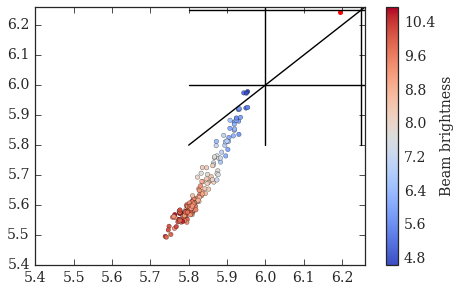

In [47]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.194
Qy = 6.244
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([5.4, 6.26])
plt.ylim([5.4, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

plt.show()

In [49]:
myDataFrame['WS_emittance_y']

2017-08-29 17:55:37.900    0.798221
2017-08-29 17:56:13.900    0.798221
2017-08-29 17:57:04.300    0.775361
2017-08-29 17:57:54.700    0.784904
2017-08-29 17:58:45.100    1.118198
2017-08-29 17:59:35.500    0.777183
2017-08-29 18:00:25.900    0.799493
2017-08-29 18:01:16.300    0.699173
2017-08-29 18:02:06.700    1.303355
2017-08-29 18:02:57.100    0.761148
2017-08-29 18:03:47.500    1.458117
2017-08-29 18:04:37.900    0.780593
2017-08-29 18:05:28.300    0.813376
2017-08-29 18:06:18.700    0.785841
2017-08-29 18:07:09.100    1.248056
2017-08-29 18:07:59.500    0.765234
2017-08-29 18:08:49.900    0.947099
2017-08-29 18:09:40.300    0.783296
2017-08-29 18:10:30.700    1.378047
2017-08-29 18:11:21.100    0.715776
2017-08-29 18:12:11.500    1.211988
2017-08-29 18:13:01.900    0.678753
2017-08-29 18:13:52.300    1.060019
2017-08-29 18:14:42.700    1.016932
2017-08-29 18:15:33.100    1.028662
2017-08-29 18:16:23.500    0.814575
2017-08-29 18:19:45.100    0.892641
2017-08-29 18:20:35.500    0

## Export the data

In [41]:
myDataFrame[['logical_PI_KFA45.K.value','peakLineDensity','WS_emittance_x','WS_emittance_y','deltaP_P_rms']].to_csv('dataFrameExported.csv')